In [14]:
# Libraries
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
import rpy2.robjects as robjects


In [ ]:


# Read the data
biobirth = pd.read_stata('biobirth.dta', convert_categoricals=False)
pgen = pd.read_stata("pgen.dta", convert_categoricals=False)
pequiv = pd.read_stata("pequiv.dta", convert_categoricals=False)
hbrutto = pd.read_stata("hbrutto.dta", convert_categoricals=False)


In [3]:
# Select relevant variables
birthdata = biobirth[['pid','sex', 'kidgeb01', 'gebjahr']]
incomedata = pgen[['pid', 'hid', 'syear', 'pglabgro']]
econdata = pequiv[['pid', 'syear', 'y11101']]
statedata = hbrutto[['hid', 'bula_v2']]


# Data Cleaning

# -- birthdata

# Remove nonobserved rows
birthdata = birthdata[birthdata['kidgeb01'] > 0]
birthdata = birthdata[birthdata['sex'] > 0]
birthdata = birthdata[birthdata['gebjahr'] > 0]

## --incomedata
incomedata = incomedata[incomedata['pglabgro'] > 0]


# In[322]:


# Merging Datasets
data = pd.merge(birthdata, incomedata, on = 'pid')
data = pd.merge(data, econdata, on = ['pid', 'syear'])
data = pd.merge(data, statedata, on = 'hid')

# In[381]:


# Creating new variables

data['age'] = data['syear'] - data['gebjahr']
data['age_kidgeb01'] = data['kidgeb01'] - data['gebjahr']
data['event_time'] = data['syear'] - data['kidgeb01']


# In[324]:


# Subsetting data
data = data[(data['age_kidgeb01'] >= 20) & (data['age_kidgeb01'] <= 45)]
data = data[(data['kidgeb01'] >= 1990) & (data['kidgeb01'] <= 2008)]
data = data[(data['event_time'] >= -5) & (data['event_time'] <= 10)]
data = data[data['age'] >= 18]


# In[325]:


# Number of distinct age and year
n_age = data['age'].nunique()
n_year = data['syear'].nunique()

# Estimation

In [15]:
# Initialize an R interpreter
r = robjects.r

# Run an R code snippet
r_code = '''
# GERMANY

## Libraries

library(haven)
library(dplyr)
library(broom)
library(stringr)


## Importing data
biobirth <- read_dta("~/Desktop/Summer Semester/Seminar on Inequality and Redistribution/Datatables/biobirth.dta")
hbrutto <- read_dta("~/Desktop/Summer Semester/Seminar on Inequality and Redistribution/Datatables/hbrutto.dta")
pgen <- read_dta("~/Desktop/Summer Semester/Seminar on Inequality and Redistribution/Datatables/pgen.dta")
pequiv <- read_dta("~/Desktop/Summer Semester/Seminar on Inequality and Redistribution/Datatables/pequiv.dta")


## Select variables
empdata <- data.frame(pgen$pid, pgen$hid ,pgen$syear, pgen$pglabgro, pgen$pgemplst)
birthdata <- data.frame(biobirth$pid, biobirth$sex, biobirth$kidgeb01, biobirth$gebjahr)
statedata <- data.frame(hbrutto$hid, hbrutto$bula_v2)
infdata <- data.frame(pequiv$pid, pequiv$syear, pequiv$y11101)


## Naming columns
colnames(empdata) <- c("persnr", "hid","year", "earnings", "empstatus")
colnames(birthdata) <- c("persnr", "sex", "kidgeb1", "birthyear")
colnames(infdata) <- c("persnr", "year", "y11101")
colnames(statedata) <- c("hid", "state")


## Data cleaning
empdata <- subset(empdata, earnings != -2 & earnings != -5)
empdata <- subset(empdata, empstatus != -1 & empstatus != -2 & empstatus  != -5)
birthdata <- subset(birthdata, kidgeb1 != -1 & kidgeb1 != -2 & kidgeb1 != -3)
birthdata <- subset(birthdata, sex != -1  & sex != -3)
birthdata <- subset(birthdata, birthyear != -1)


## Merging datasets
data <- merge(empdata, birthdata, by = 'persnr')
data <- merge(data, infdata, by = c("persnr","year"))
data <- merge(data, statedata, by = "hid")


## Creating new variables
data$age <- data$year - data$birthyear
data$age_firstbirth <- data$kidgeb1 - data$birthyear


## Subsetting data
data <- subset(data, age_firstbirth >= 20 & age_firstbirth <= 45)
data <- subset(data, kidgeb1 <= 2008)
data <- subset(data, kidgeb1 >= 1990)
data$event_time <- data$year - data$kidgeb1
data <- subset(data, event_time >= -5 & event_time <= 10)


## Estimation

regression_m <- lm(earnings ~ factor(event_time) + factor(age) + factor(year) - 1, data = data[data$sex == 1, ])
regression_w <- lm(earnings ~ factor(event_time) + factor(age) + factor(year) - 1, data = data[data$sex == 2, ])

tidy_regression_m <- tidy(regression_m)
tidy_regression_w <- tidy(regression_w)

### Coefficients

write.csv(tidy_regression_m, "coefficients_m.csv")
write.csv(tidy_regression_w, "coefficients_w.csv")
'''
r(r_code)

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## Men

In [17]:
# Import coefficients
coefficients_m = pd.read_csv("coefficients_m.csv", index_col=False)
coefficients_long_m = coefficients_m[["Unnamed: 0","term","estimate"]]
coefficients_long_m = coefficients_m.pivot_table(columns='term', values='estimate')
coefficients_m


# In[328]:


min_age = int(data['age'].min())
max_age = int(data['age'].max())

min_year = int(data['syear'].min())
max_year = int(data['syear'].max())


# In[330]:


# Generate predicted values
df['pred_m_age'] = 0
df['pred_m_year'] = 0
for i in range(min_age, max_age-1):
    df.loc[df['sex'] == 1, 'pred_m_age'] += df.loc[df['sex'] == 1, f'age_{i}.0'] * coefficients_long_m.loc['estimate', f'factor(age){i}']
for i in range(min_year + 1, max_year + 1):
    df.loc[df['sex'] == 1, 'pred_m_year'] += df.loc[df['sex'] == 1, f'syear_{i}.0'] * coefficients_long_m.loc['estimate', f'factor(year){i}']

data['pred_m'] = df['pred_m_age'] + df['pred_m_year']


# In[332]:


data['predicted_m'] = data.groupby(['event_time', 'sex'])['pred_m'].transform('mean')
data.loc[df['sex'] == 2, 'pred_m'] = np.nan


# In[333]:


predicted_m = data.drop_duplicates(subset=['sex', 'event_time', 'predicted_m'])
predicted_m = predicted_m.dropna()


# In[334]:


event_time_m = coefficients_m[coefficients_m['term'].str.startswith('factor(event_time)')]
event_time_m['term'] = event_time_m['term'].apply(lambda x: x.split(')')[-1] if isinstance(x, str) and x.startswith('factor(event_time)') else x)


# In[335]:


event_time_m = event_time_m.rename(columns={'term': 'event_time'})
event_time_m['event_time'] = event_time_m['event_time'].astype('float64')


# In[360]:


result_df_m = pd.merge(predicted_m, event_time_m, on = 'event_time')
result_df_m['perc_coef_m'] = result_df_m['estimate'] / result_df_m['predicted_m']

/var/folders/1p/063yl0ms01z8skkqfmk94z9c0000gn/T/ipykernel_16286/3726371883.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_time_m['term'] = event_time_m['term'].apply(lambda x: x.split(')')[-1] if isinstance(x, str) and x.startswith('factor(event_time)') else x)


,pid,sex,kidgeb01,gebjahr,hid,syear,pglabgro,y11101,bula_v2,age,age_kidgeb01,event_time,pred_m,predicted_m,Unnamed: 0,estimate,std.error,statistic,p.value,perc_coef_m
0,910603.0,1,1995.0,1959.0,91065,1996.0,2096.0,75.500000,-8,37.0,36.0,1.0,2955.784420,2281.359885,7,238.342828,111.125548,2.144807,0.031969,0.104474
1,910603.0,1,1995.0,1959.0,91065,1997.0,2301.0,76.500000,-8,38.0,36.0,2.0,3026.294731,2442.096415,8,263.036223,111.132534,2.366870,0.017940,0.107709
2,910603.0,1,1995.0,1959.0,91065,1998.0,2199.0,77.900002,-8,39.0,36.0,3.0,3175.269810,2615.580568,9,238.337354,111.075676,2.145720,0.031896,0.091122
3,910603.0,1,1995.0,1959.0,91065,1999.0,4217.0,78.599998,-8,40.0,36.0,4.0,3330.077326,2765.877433,10,209.663837,111.076858,1.887556,0.059086,0.075804
4,7303.0,1,2000.0,1970.0,105317,1997.0,2301.0,76.500000,-8,27.0,30.0,-3.0,1601.703987,1763.417159,3,222.613758,110.869475,2.007890,0.044655,0.126240
5,7303.0,1,2000.0,1970.0,105317,1998.0,3017.0,77.900002,-8,28.0,30.0,-2.0,1655.230878,1878.736365,4,244.786747,111.237245,2.200583,0.027766,0.130293
6,7303.0,1,2000.0,1970.0,105317,1999.0,3022.0,78.599998,-8,29.0,30.0,-1.0,1827.129312,2007.495150,5,262.483139,111.198297,2.360496,0.018251,0.130752
7,7303.0,1,2000.0,1970.0,105317,2000.0,2761.0,79.099998,-8,30.0,30.0,0.0,2113.865245,2131.793076,6,292.212270,111.147083,2.629059,0.008562,0.137073
8,7303.0,1,2000.0,1970.0,105317,2005.0,4333.0,84.900002,-8,35.0,30.0,5.0,2830.391574,2929.924680,11,222.860108,111.092598,2.006075,0.044849,0.076063
9,7303.0,1,2000.0,1970.0,105317,2006.0,5200.0,86.199997,-8,36.0,30.0,6.0,2902.927963,3064.595034,12,205.430585,111.119250,1.848740,0.064496,0.067034


## Women

In [19]:
coefficients_w = pd.read_csv("coefficients_w.csv", index_col=False)
coefficients_long_w = coefficients_w[["Unnamed: 0","term","estimate"]]
coefficients_long_w = coefficients_w.pivot_table(columns='term', values='estimate')
coefficients_long_w 
# In[343]:


# Generate predicted values
df['pred_w_age'] = 0
df['pred_w_year'] = 0
for i in range(min_age, max_age-4):
    df.loc[df['sex'] == 2, 'pred_w_age'] += df.loc[df['sex'] == 2, f'age_{i}.0'] * coefficients_long_w.loc['estimate', f'factor(age){i}']
for i in range(min_year + 2, max_year + 1):
    df.loc[df['sex'] == 2, 'pred_w_year'] += df.loc[df['sex'] == 2, f'syear_{i}.0'] * coefficients_long_w.loc['estimate', f'factor(year){i}']

data['pred_w'] = df['pred_w_age'] + df['pred_w_year']
data


# In[344]:


data['predicted_w'] = data.groupby(['event_time', 'sex'])['pred_w'].transform('mean')
data.loc[df['sex'] == 1, 'pred_w'] = np.nan
data


# In[345]:


data['predicted_w'] = data.groupby(['event_time', 'sex'])['pred_w'].transform('mean')
data


# In[348]:


predicted_w = data.drop_duplicates(subset=['sex', 'event_time', 'predicted_w'])
predicted_w = predicted_w.dropna(subset=['predicted_w'])
predicted_w


# In[349]:


event_time_w = coefficients_w[coefficients_w['term'].str.startswith('factor(event_time)')]
event_time_w['term'] = event_time_w['term'].apply(lambda x: x.split(')')[-1] if isinstance(x, str) and x.startswith('factor(event_time)') else x)


# In[350]:





# In[351]:


event_time_w = event_time_w.rename(columns={'term': 'event_time'})
event_time_w['event_time'] = event_time_w['event_time'].astype('float64')


# In[358]:


result_df_w = pd.merge(predicted_w, event_time_w, on = 'event_time')
result_df_w['perc_coef_w'] = result_df_w['estimate'] / result_df_w['predicted_w']

/var/folders/1p/063yl0ms01z8skkqfmk94z9c0000gn/T/ipykernel_16286/3204391906.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_time_w['term'] = event_time_w['term'].apply(lambda x: x.split(')')[-1] if isinstance(x, str) and x.startswith('factor(event_time)') else x)


## Plot

In [20]:
event_study_results = pd.merge(result_df_m[['event_time', 'perc_coef_m']], result_df_w[['event_time', 'perc_coef_w']], on='event_time')
event_study_results = event_study_results.sort_values(by='event_time')
event_study_results

,event_time,perc_coef_m,perc_coef_w
11,-5.0,0.136692,0.211434
12,-4.0,0.131265,0.187101
4,-3.0,0.126240,0.174665
5,-2.0,0.130293,0.173199
6,-1.0,0.130752,0.161075
7,0.0,0.137073,0.132711
0,1.0,0.104474,-0.210624
1,2.0,0.107709,-0.273365
2,3.0,0.091122,-0.272577
3,4.0,0.075804,-0.300711


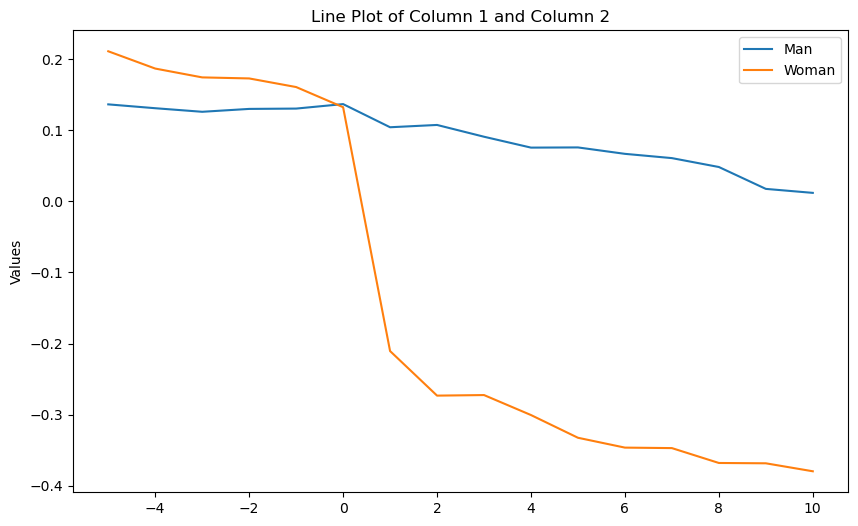

In [21]:
# Event Study Plot
plt.figure(figsize=(10, 6))
plt.plot(event_study_results['event_time'],event_study_results['perc_coef_m'], label='Man')
plt.plot(event_study_results['event_time'],event_study_results['perc_coef_w'], label='Woman')
plt.title('Line Plot of Column 1 and Column 2')
plt.xlabel('')
plt.ylabel('Values')
plt.legend()
plt.show()

## Child Penalty

In [22]:
mean_m = event_study_results['perc_coef_m'].mean()
mean_w = event_study_results['perc_coef_w'].mean()

child_penalty = mean_m - mean_w
child_penalty

0.2258847516268456